In [1]:
#load libraries and setup file
import sys,os
root_path = os.path.abspath(os.path.join('..'))
print(root_path)
if root_path not in sys.path:
    sys.path.append(root_path)
%run -i "../lib/utils/ipynb_setup.py"
%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/max/Dropbox/scripts/Projects/decisionmaking/code/oppcosts


In [3]:
#plotting
import matplotlib.pyplot as pl
import seaborn as sns
sns.set_style("ticks", {'axes.grid' : True})
pl.rc("figure", facecolor="white",figsize = (8,8))
#pl.rc("figure", facecolor="gray",figsize = (8,8))
pl.rc('text', usetex=True)
pl.rc('text.latex', preamble=[r'\usepackage{amsmath}'])
pl.rc('lines',markeredgewidth = 2)
pl.rc('font',size = 12)

In [4]:
#check these are consistent with dyn_prog_model.npy
para=dict()
para['T']=15
para['T_ITI']=7.5 #para['T']/2=7.5 in primate experiments set to 8 so that all trial durations are integers
para['p']=1/2
para['tp']=0

## Import data

In [905]:
if not os.path.exists(os.getcwd()+'/df_data'):
    df_data=load_data()
    df_data.to_pickle('df_data')
else:
    df_data=pd.read_pickle('df_data')
#     df_data=pd.read_pickle('df_data_tdec_as_int')

Note that the block lengths differ for the two subjects and thus add to any inter subject varibability

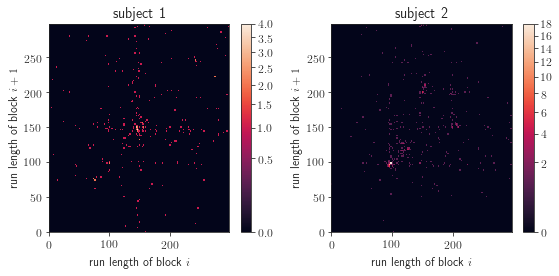

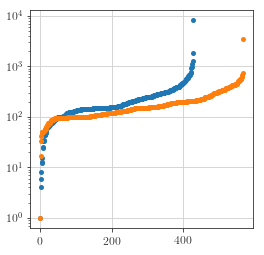

In [901]:
fig,ax=pl.subplots(1,2,figsize=(8,4))
fig2,ax2=pl.subplots(figsize=(4,4))
avg_blocksize=[]
import matplotlib.colors as mcolors
for sit, subject in enumerate(range(1,3)):
    df_tmp=df_data[df_data.idSubject==subject].reset_index(drop=True)
    df_tmp['nPostInterval_diff']=df_tmp.nPostInterval.diff()
    cond=df_tmp['nPostInterval_diff']!=0
    diffinds=np.diff(df_tmp[cond].index.values)
    h=ax[sit].hist2d(diffinds[1:], diffinds[:-1], bins=range(0,300,2),norm=mcolors.PowerNorm(0.5));
    ax[sit].set_title('subject '+str(subject))
    fig.colorbar(h[3],ax=ax[sit])
    ax[sit].set_xlabel('run length of block $i$')
    ax[sit].set_ylabel('run length of block $i+1$')
    avg_blocksize.append(np.mean(diffinds))
    ax2.plot(np.sort(diffinds),'.')
#     ax2.set_ylim(50,500)
    ax2.set_yscale('log')
fig.tight_layout()

In [364]:
from lib.filter_lib import *
from lib.filter_plotting import *

## run model

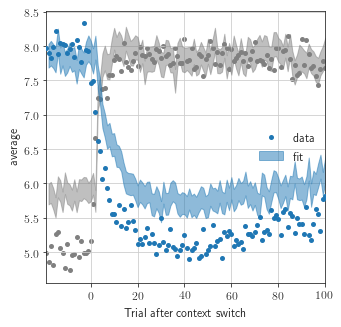

In [903]:
paravec=np.power(2,np.arange(11))*average_trial_duration
paras=[paravec[4],5,paravec[5]]
model_paras_S1_taus={'tau_context':12*average_trial_duration,  
                'tau_context_plus':30*average_trial_duration, 
                'tau_long':20000,#1000*average_trial_duration,
                'Tcontext_bias':2,
                'sense_power':8.839935, 
                'shared_noise_variance_factor':0,
                'tau_shared_noise':1,
                'context_noise_bias':0,
                'context_noise_variance_factor':0
                }
df_act=df_data[df_data.idSubject==2].reset_index(drop=True)
df_mod=get_model_output(df_act,model_paras_S1_taus,seed=1)

plot_transitions({'act':df_act,'mod':df_mod})

In [817]:
df_act.columns

Index(['Nt', 'seq', 'nPostInterval', 'idSubject', 'nCorrectChoice',
       'tDecision', 'nChoiceMade', 'p_suc_seq', 'duration', 'trialRR',
       'nPostInterval_diff', 'block_len'],
      dtype='object')

In [824]:
df_mod.columns

Index(['seq', 'nChoiceMade', 'tDecision', 'nPostInterval', 'trialRR',
       'rho_long', 'rho_context', 'T_context', 'duration'],
      dtype='object')

No handles with labels found to put in legend.


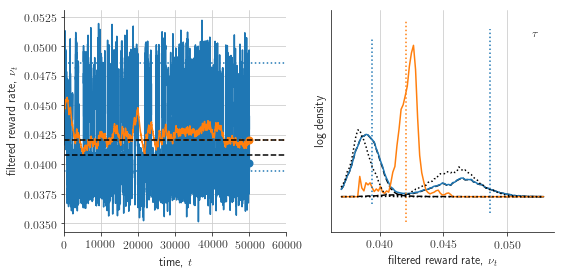

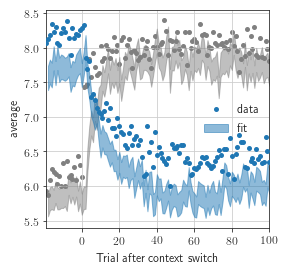

In [904]:
# opt_paras=np.load('opt_paras_v9_opt_neldermead_finejusttaus_1_1000.npy')
model_paras_S1_taus={'tau_context':407.047901,
                'sense_power':8.839935, 
                'tau_long':31620.805644,
                'Tcontext_bias':0,
                'shared_noise_variance_factor':0,
                'tau_shared_noise':1,
                'context_noise_bias':0,
                'context_noise_variance_factor':0
                }
df_act=df_data[df_data.idSubject==1].reset_index(drop=True)

df_mod=get_model_output(df_act,model_paras_S1_taus,seed=10)

# df_mod.sensitivity_factor.hist()
# plot_transitions({'act':df_act,'mod':df_mod})

fig,ax=pl.subplots(1,2,figsize=(8,4))
# ax.plot(df_act.rho_context,df_mod.rho_context)
it=int(5e4)
ax[0].plot(df_mod.rho_context[:it+1],color='C0')
ax[0].plot([it],[df_mod.rho_context[it]],'o',color='C0')
ax[0].plot(df_mod.rho_long[:it+1],color='C1')
ax[0].plot([it],[df_mod.rho_long[it]],'o',color='C1')
ax[0].set_xlabel('trial')
ax[0].set_ylabel('filtered reward rate')
# ax[0].text(it*(1.1),ax.get_ylim()[0]+0.95*np.diff(ax.get_ylim()),r'\textbf{$\rho_\textrm{short}$}',color='C0',fontsize=14)
# ax[0].text(it*(1.1),ax.get_ylim()[0]+0.85*np.diff(ax.get_ylim()),r'\textbf{$\rho_\textrm{long}$}',color='C1',fontsize=14)
ax[0].set_xlim(0,it*(1.2))
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
mean_rho_context=[]
block_trials=[]
binvec=np.linspace(0.037,0.053,100)
for bit,b in enumerate(block_times):
    dftmp=df_mod[(df_mod.nPostInterval==b)]
    target=(dftmp.nCorrectChoice==dftmp.nChoiceMade)
    mean_rho_context.append(target.sum()/dftmp.duration.sum())
    ax[0].plot(ax[0].get_xlim(),[target.sum()/dftmp.duration.sum()]*2,'C0:')
    counts,bins=np.histogram(dftmp.rho_context.values,binvec,density=True)
    ax[1].plot(bins[:-1],len(dftmp)/len(df_mod)*counts,'k--')#,label=r'$10^'+str(int(np.log10(zeta*(p_0_to_1+p_1_to_0))))+'T_{cs}$')
    block_trials.append(len(dftmp))
counts,bins=np.histogram(df_mod.rho_context.values,binvec,density=True)
ax[1].plot(bins[:-1],counts,'C0-')#,label=r'$10^'+str(int(np.log10(zeta*(p_0_to_1+p_1_to_0))))+'T_{cs}$')
counts,bins=np.histogram(df_mod.rho_long.values,binvec,density=True)
ax[1].plot(bins[:-1],counts,color='C1')#,label=r'$10^'+str(int(np.log10(zeta*(p_0_to_1+p_1_to_0))))+'T_{cs}$')
mean_rho_long=(df_mod.nCorrectChoice==df_mod.nChoiceMade).sum()/df_mod.duration.sum()
ax[0].plot(ax[0].get_xlim(),[mean_rho_long]*2,'C1:')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].set_xlabel(r'time, $t$')
ax[0].set_ylabel(r'filtered reward rate, $\nu_t$')
ax[1].set_xlabel(r'filtered reward rate, $\nu_t$')
ax[1].set_ylabel('log density')
# ax[1].set_yscale('log')
# ax[1].set_ylim([1e0,10**(3.5)])
# ax[0].plot(ax[0].get_xlim(),[rhovec[0]]*2,'k--')
# ax[0].plot(ax[0].get_xlim(),[rhovec[1]]*2,'k--')
# ax[0].plot(ax[0].get_xlim(),[rhoavg]*2,'k--')
# ax[0].set_ylim(0.04,0.06)
# ax[0].set_xlim(0,100000)
# ax[1].set_xticks([rhovec[0],rhoavg,rhovec[1]])
# ax[1].set_xticklabels([r'$\rho_{\textrm{slow}}$',r'$\bar{\rho}$',r'$\rho_{\textrm{fast}}$'])
ax[1].set_yticks([])
ax[1].plot([mean_rho_context[0]]*2,ax[1].get_ylim(),'C0:')
ax[1].plot([mean_rho_context[1]]*2,ax[1].get_ylim(),'C0:')
ax[1].plot([mean_rho_long]*2,ax[1].get_ylim(),'C1:')
# ax[0].ticklabel_format(axis='x',style='sci',scilimits=(4,4))
# ax[0].set_ticklabels([]
ax[1].legend(frameon=False,prop={'size': 18},title=r'$\tau$')

# cmap = mpl.colors.LinearSegmentedColormap.from_list(
#     'Custom cmap', colorsre, len(colorsre))
# # define the bins and normalize
# bounds = np.append(np.log10(zetavec).astype('int'),np.log10(zetavec[-1])+1)-0.5
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
# # create a second axes for the colorbar
# ax2 = fig.add_axes([1.02, 0.3, 0.02, 0.6])
# cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
#     spacing='proportional', ticks=bounds,boundaries=bounds, format='%1i')
# ax2.set_yticks(np.arange(2,int(np.log10(steps)))+1)
# ax2.set_yticklabels([r'$10^{'+str(int(b))+'}$' for b in (bounds[:-1]+1)])

for bit,b in enumerate(block_times):
    dftmp=df_act.copy()
    dftmp=dftmp[dftmp.nPostInterval==b]
    dftmp=get_model_output(dftmp,model_paras_S1_taus,seed=10)
    target=(dftmp.nCorrectChoice==dftmp.nChoiceMade)
    mean_rho_context.append(target.sum()/dftmp.duration.sum())
#     ax[0].plot(ax[0].get_xlim(),[target.sum()/dftmp.duration.sum()]*2,'k--')
    counts,bins=np.histogram(dftmp.rho_context.values,binvec,density=True)
    ax[1].plot(bins[:-1],block_trials[bit]/(2*len(dftmp))*counts,'k:')#,label=r'$10^'+str(int(np.log10(zeta*(p_0_to_1+p_1_to_0))))+'T_{cs}$')

target=(df_mod.nCorrectChoice==df_mod.nChoiceMade)
ax[0].plot(ax[0].get_xlim(),[target.sum()/df_mod.duration.sum()]*2,'k--')
target=(df_act.nCorrectChoice==df_act.nChoiceMade)
ax[0].plot(ax[0].get_xlim(),[target.sum()/df_act.duration.sum()]*2,'k--')


fig.tight_layout()
fig.savefig('filtered_rew.pdf', transparent=True,bbox_inches='tight',dpi=300)
# plot_transitions({'act':df_act,'mod':df_mod},ax=None,measure='rho_context')
# plot_transitions({'act':df_act,'mod':df_mod},ax=None,measure='trialRR')
# plot_transitions({'act':df_act,'mod':df_mod},ax=None,measure='T_context')
fig,ax=pl.subplots(figsize=(4,4))
ax=plot_transitions({'act':df_act,'mod':df_mod},ax=ax)
fig.savefig('transition.png', transparent=True,bbox_inches='tight',dpi=300)


In [888]:
# root_filename='v7_opto_neldermead_rholongTcontextbias_1_1000'
# root_filename='v8_opto_neldermead_justtaus_1_1000'
# root_filename='v9_opt_neldermead_finejusttaus_1_1000'
root_filename='v10_opt_neldermead_select'

run_evaluation('opt',1,df_data,root_filename,model_type='tau_only')

Iter      tauc      Tbias     taucp     
1 630.000000 21000.000000 13.500000 
2 570.000000 22000.000000 13.500000 
3 600.000000 24000.000000 12.000000 
4 600.000000 24000.000000 12.000000 
5 510.000000 27666.666667 9.500000 
6 570.000000 31333.333333 5.500000 
7 570.000000 31333.333333 5.500000 
8 570.000000 31333.333333 5.500000 
9 570.000000 31333.333333 5.500000 
10 570.000000 31333.333333 5.500000 
11 525.000000 31000.000000 6.750000 
12 519.166667 32333.333333 5.708333 
13 519.166667 32333.333333 5.708333 
14 433.194444 32277.777778 7.951389 
15 433.194444 32277.777778 7.951389 
16 433.194444 32277.777778 7.951389 
17 433.194444 32277.777778 7.951389 
18 411.844993 31400.548697 8.989369 
19 411.844993 31400.548697 8.989369 
20 411.844993 31400.548697 8.989369 
21 411.844993 31400.548697 8.989369 
22 411.844993 31400.548697 8.989369 
23 404.070883 31482.148301 8.970877 
24 406.339961 31639.922458 8.851502 
25 406.339961 31639.922458 8.851502 
26 406.339961 31639.922458 8.851502 
27

KeyboardInterrupt: 

some decisions at t=0!


/home/max/Dropbox/scripts/Projects/decisionmaking/code/oppcosts/lib/filter_plotting.py:203: RuntimeWarning: invalid value encountered in less
  z_d[z_d<0]=0


some decisions at t=0!


/home/max/Dropbox/scripts/Projects/decisionmaking/code/oppcosts/lib/filter_plotting.py:203: RuntimeWarning: invalid value encountered in less
  z_d[z_d<0]=0
/home/max/Dropbox/scripts/Projects/decisionmaking/code/oppcosts/lib/filter_plotting.py:203: RuntimeWarning: invalid value encountered in less
  z_d[z_d<0]=0
/home/max/Dropbox/scripts/Projects/decisionmaking/code/oppcosts/lib/filter_plotting.py:203: RuntimeWarning: invalid value encountered in less
  z_d[z_d<0]=0


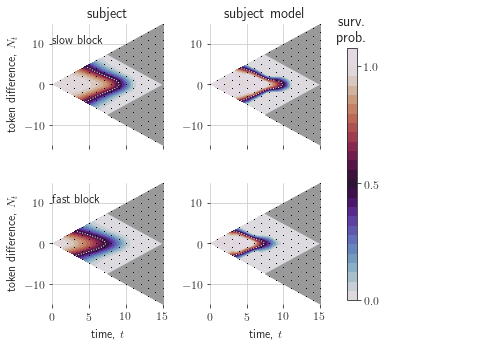

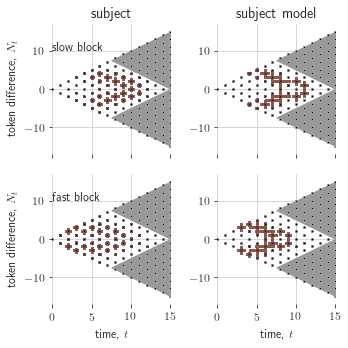

In [890]:
plot_policies({'act':df_act,'mod':df_mod},file_name='policies_s1')

single context

In [ ]:
dftmp=df_act.copy()
dftmp.nPostInterval=50
df_mod=get_model_output(df_act,model_paras_S1_taus,seed=10)
df_mod

## optimize $(\tau_{long},\tau_{short})$-Model

In [593]:
# root_filename='v1_1_1000'
# root_filename='v2_1_1000'
# root_filename='v4_first20last20_1_1000'
# root_filename='v5_twostream_1_1000'
# root_filename='v6_Tcontextbias_1_1000'
root_filename='v9_grid_neldermead_finejusttaus_1_1000'
run_evaluation('grid',1,df_data,root_filename,model_type='tau_only')

1 of 51 took 2.9725682735443115
2 of 51 took 140.63505363464355
3 of 51 took 138.63978695869446
4 of 51 took 137.19988107681274
5 of 51 took 132.1539182662964
6 of 51 took 127.5474100112915
7 of 51 took 125.75337076187134
8 of 51 took 127.4936933517456
9 of 51 took 121.65308141708374
10 of 51 took 119.4644181728363
11 of 51 took 119.1396849155426
12 of 51 took 115.38977670669556
13 of 51 took 112.45404005050659
14 of 51 took 107.8725950717926
15 of 51 took 105.8031587600708
16 of 51 took 100.53220844268799
17 of 51 took 96.64963221549988
18 of 51 took 94.13658380508423
19 of 51 took 94.86534190177917
20 of 51 took 92.01932644844055
21 of 51 took 89.70773434638977
22 of 51 took 86.85739588737488
23 of 51 took 81.37184238433838
24 of 51 took 79.60974407196045
25 of 51 took 76.59976720809937
26 of 51 took 73.87997364997864
27 of 51 took 72.66523742675781
28 of 51 took 70.09301805496216
29 of 51 took 68.60199451446533
30 of 51 took 62.50997281074524
31 of 51 took 59.815266609191895
32 of 5

In [521]:
def dummy(row):
    return get_trial_duration(row.tDecision,1-row.nPostInterval/200)
df_act['duration']=df_act.apply(dummy, axis=1)

In [713]:
# root_filename='v7_opto_neldermead_rholongTcontextbias_1_1000'
# root_filename='v8_opto_neldermead_justtaus_1_1000'
root_filename='v9_opt_neldermead_finejusttaus_1_1000'
run_evaluation('opt',1,df_data,root_filename,model_type='tau_only')

Iter      tauc      Tbias     
1 613.200000 9344.000000 
2 613.200000 9344.000000 
3 613.200000 9344.000000 
4 612.287500 9446.200000 
5 612.743750 9395.100000 
6 612.743750 9395.100000 
7 612.629688 9407.875000 
8 612.629688 9407.875000 
9 612.686719 9401.487500 
10 612.686719 9401.487500 
11 612.686719 9401.487500 
12 612.686719 9401.487500 
13 612.686719 9401.487500 
14 612.686719 9401.487500 
15 612.686719 9401.487500 
16 612.686719 9401.487500 
17 612.686719 9401.487500 
18 612.686719 9401.487500 
19 612.686719 9401.487500 
20 612.686719 9401.487500 
21 612.686719 9401.487500 
22 612.686719 9401.487500 
23 612.686719 9401.487500 
24 612.686719 9401.487500 
25 612.686719 9401.487500 
26 612.686719 9401.487500 
27 612.686719 9401.487500 
28 612.686719 9401.487500 
29 612.686719 9401.487500 
30 612.686719 9401.487500 
31 612.686719 9401.487500 
32 612.686719 9401.487500 
33 612.686719 9401.487500 
34 612.686719 9401.487500 
35 612.686719 9401.487500 
36 612.686719 9401.487500 
37 612

In [632]:
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import inset_locator

/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


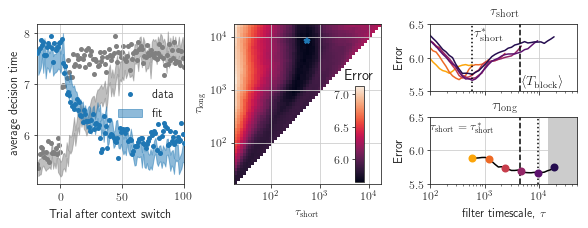

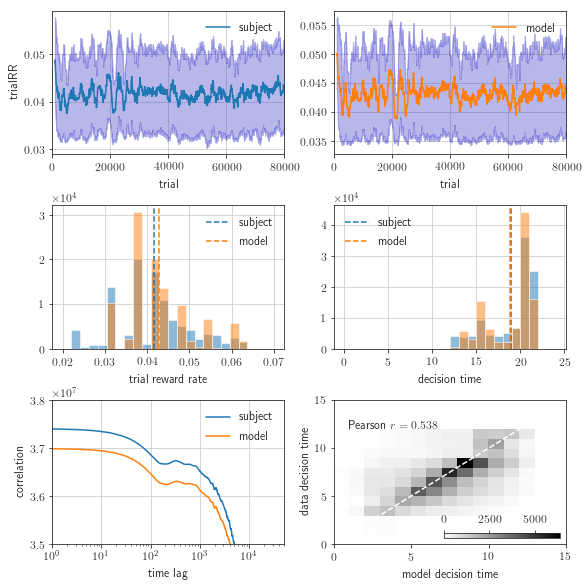

In [715]:
# error_grid=np.load('error_grid_v1_1_1000.npy')
# error_grid=np.load('error_grid_v2_1_1000.npy')
# error_grid=np.load('error_grid_v3_first20_1_1000.npy')
# error_grid=np.load('error_grid_v4_first20last20_1_1000.npy')
# error_grid=np.load('error_grid_v5_twostream_1_1000.npy')
# error_grid=np.load('error_grid_v6_Tcontextbias_1_1000.npy')
# error_grid=np.load('error_grid_v8_grid_neldermead_justtaus_1_1000.npy')

error_grid=np.load('error_grid_v9_grid_neldermead_finejusttaus_1_1000.npy')
error_grid[error_grid==0]=np.nan
tau_shortvec=np.power(2,np.linspace(0,10,51))*average_trial_duration
tau_longvec=np.power(2,np.linspace(0,10,51))*average_trial_duration
optinds=np.unravel_index(np.nanargmin(error_grid),(len(tau_shortvec),len(tau_longvec)))

fig=pl.figure(figsize=(8,3))
axt=fig.add_subplot(132)

im=axt.imshow(error_grid.T,origin='lower')
axt.plot([optinds[0]],[optinds[1]],'*')
axt.set_aspect('auto')
cbar_ax=inset_locator.inset_axes(axt,width='20%',height='100%',bbox_to_anchor=(0.63,0.05,.3,.6),bbox_transform=axt.transAxes)
cb=pl.colorbar(im,cax=cbar_ax)
axt.set_yticks(51/10*np.log2(np.power(10,np.arange(2,5))/average_trial_duration))
axt.set_yticklabels([r'$10^'+str(n)+'$' for n in np.arange(2,5)])
axt.set_xticks(51/10*np.log2(np.power(10,np.arange(2,5))/average_trial_duration))
axt.set_xticklabels([r'$10^'+str(n)+'$' for n in np.arange(2,5)])
cb.ax.yaxis.set_ticks_position('left')
# cbar = axt.figure.colorbar(im, ax=axt,fraction=0.045)#, **cbar_kw)
cbar_ax.set_title('Error')
axt.set_xlabel(r'$\tau_\textrm{short}$')
axt.set_ylabel(r'$\tau_\textrm{long}$')

ax=(fig.add_subplot(233),fig.add_subplot(236))
colorsre = pl.cm.inferno_r(np.linspace(0.2, 1., 7))
for it,row in enumerate(error_grid[:,25::5].T):
    ax[0].plot(tau_shortvec,row,color=colorsre[it])
ax[0].set_xscale('log')
ax[0].set_ylim(5.5,6.5)
ax[0].set_xlim(1e2,5e4)
ax[0].set_xticklabels([])
ax[0].axvline(avg_blocksize[0]*average_trial_duration,ls='--',color='k')
ax[0].axvline(tau_shortvec[optinds[0]],ls=':',color='k')
ax[0].set_ylabel('Error')
ax[0].text(tau_shortvec[optinds[0]]*1.1,6.25,r'$\tau^*_\textrm{short}$',fontsize=14)
ax[0].text(avg_blocksize[0]*average_trial_duration*1.1,5.55,r'$\langle T_\textrm{block}\rangle$',fontsize=14)

# AT=AnchoredText('short',loc=2,frameon=False,prop=dict(fontsize=16))
ax[0].set_title(r'$\tau_\textrm{short}$')
# ax[0].add_artist(AT)
ax[1].set_xlim(1e2,5e4)
ax[1].set_ylim(5.5,6.5)
ax[1].fill_between([80000/100*average_trial_duration,ax[1].get_xlim()[1]],[ax[1].get_ylim()[0]]*2,y2=[ax[1].get_ylim()[1]]*2,color=[0.8]*3,zorder=0)
ax[1].axvline(avg_blocksize[0]*average_trial_duration,ls='--',color='k')
ax[1].axvline(tau_longvec[optinds[1]],ls=':',color='k')
ax[1].plot(tau_longvec,error_grid[optinds[0],:],'k-')
for tit,tau in enumerate(tau_longvec[25::5]):
    ax[1].plot([tau],[error_grid[optinds[0],25+5*tit]],'o',color=colorsre[tit])
ax[1].set_xscale('log')
ax[1].set_ylabel('Error')
ax[1].set_xlabel(r'filter timescale, $\tau$')

# AT=AnchoredText(r'$\tau_\textrm{short}=\tau^*_\textrm{short}$',loc=2,frameon=False,prop=dict(fontsize=16))
ax[1].set_title(r'$\tau_\textrm{long}$')
ax[1].text(ax[1].get_xlim()[0],ax[1].get_ylim()[1]*0.96,r'$\tau_\textrm{short}=\tau^*_\textrm{short}$')
# ax[1].add_artist(AT)
# ax[1].text(80000/100*average_trial_duration*1.1,6.25,r'$\tau_\textrm{exp}$',fontsize=14)

opt_paras=np.load('opt_paras_v9_opt_neldermead_finejusttaus_1_1000.npy')
model_paras_S1_taus={'tau_context':opt_paras[0],  
                'tau_context_plus':opt_paras[0], 
                'tau_long':opt_paras[1],
                'Tcontext_bias':0,
                'shared_noise_variance_factor':0,
                'tau_shared_noise':1,
                'context_noise_bias':0,
                'context_noise_variance_factor':0
                }
df_act=df_data[df_data.idSubject==1].reset_index(drop=True)
df_mod=get_model_output(df_act,model_paras_S1_taus,seed=10)
ax=fig.add_subplot(131)
axp=plot_transitions({'act':df_act,'mod':df_mod},ax=ax)
axp.set_ylabel('average decision time')
fig.tight_layout(pad=0.1)
fig.savefig('model_fitting.png', transparent=True,bbox_inches="tight",dpi=300)

plot_stats({'act':df_act,'mod':df_mod},'stats_s1')


some decisions at t=0!


/home/max/Dropbox/scripts/Projects/decisionmaking/code/oppcosts/lib/filter_plotting.py:203: RuntimeWarning: invalid value encountered in less
  CS=ax.contourf(tvecdense,Nvecdense,z_d,30,cmap=pl.cm.twilight,vmax=1., vmin=0.)#,alpha=0.8)


some decisions at t=0!


/home/max/Dropbox/scripts/Projects/decisionmaking/code/oppcosts/lib/filter_plotting.py:203: RuntimeWarning: invalid value encountered in less
  CS=ax.contourf(tvecdense,Nvecdense,z_d,30,cmap=pl.cm.twilight,vmax=1., vmin=0.)#,alpha=0.8)
/home/max/Dropbox/scripts/Projects/decisionmaking/code/oppcosts/lib/filter_plotting.py:203: RuntimeWarning: invalid value encountered in less
  CS=ax.contourf(tvecdense,Nvecdense,z_d,30,cmap=pl.cm.twilight,vmax=1., vmin=0.)#,alpha=0.8)
/home/max/Dropbox/scripts/Projects/decisionmaking/code/oppcosts/lib/filter_plotting.py:203: RuntimeWarning: invalid value encountered in less
  CS=ax.contourf(tvecdense,Nvecdense,z_d,30,cmap=pl.cm.twilight,vmax=1., vmin=0.)#,alpha=0.8)


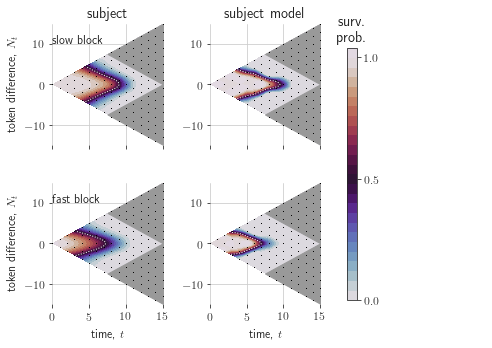

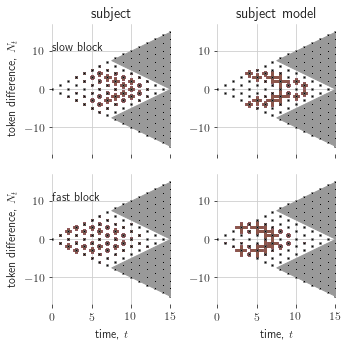

In [720]:
plot_policies({'act':df_act,'mod':df_mod},file_name='policies_s1')

[ 1.22349046e+02  6.71656849e+00  1.19541759e+03 -4.01120968e-03]


/home/max/anaconda3/envs/py3fresh/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


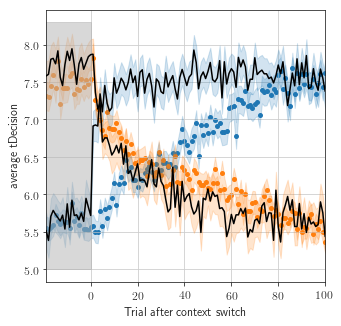

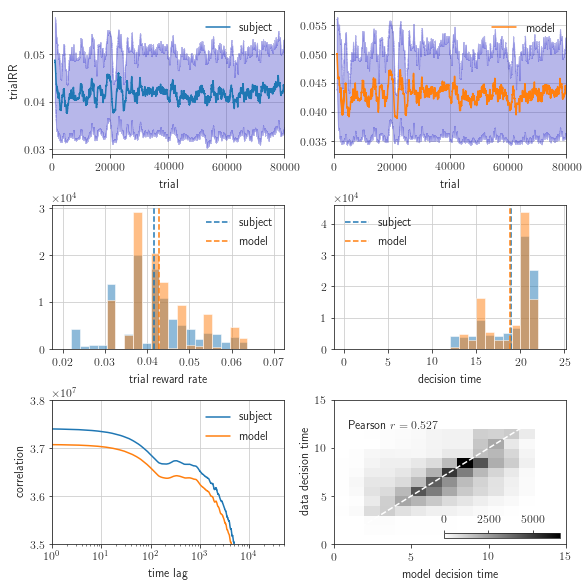

In [450]:
paras=np.load('opt_paras_v7_opto_neldermead_rholongTcontextbias_1_1000.npy')
paras[1]+=7
print(paras)
model_paras_S1_taus={'tau_context':paras[0],  
                'tau_context_plus':paras[2], 
                'tau_long':2e4,#1000*average_trial_duration,
                'Tcontext_bias':paras[1],
                'rho_long_bias':paras[3],
                'shared_noise_variance_factor':0,
                'tau_shared_noise':5,
                'context_noise_bias':0,
                'context_noise_variance_factor':0
                }
model_paras_S1_taus={'tau_context':paras[2]*3/4,#*2/4,  
                'tau_context_plus':paras[2]*3/4,#*2/4, 
                'tau_long':1e4,#1000*average_trial_duration,
                'Tcontext_bias':0,
                'rho_long_bias':0,
                'shared_noise_variance_factor':5,
                'tau_shared_noise':5,
                'context_noise_bias':0,
                'context_noise_variance_factor':0
                }
df_act=df_data[df_data.idSubject==1].reset_index(drop=True)
df_mod=get_model_output(df_act,model_paras_S1_taus,seed=1)

plot_transitions({'act':df_act,'mod':df_mod})
# check_error(subject,df_data,paras)
plot_stats({'act':df_act,'mod':df_mod})
# plot_policies({'act':df_act,'mod':df_mod})

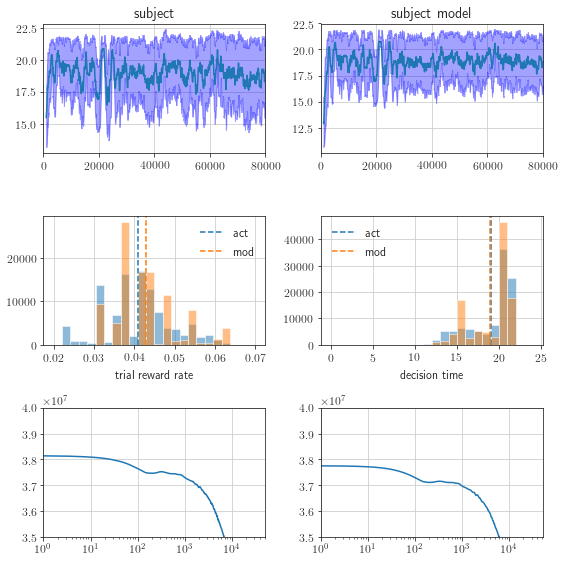

In [304]:
plot_stats({'act':df_act,'mod':df_mod})

## neural urgency comparison

No handles with labels found to put in legend.
No handles with labels found to put in legend.


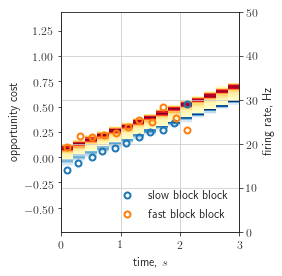

In [813]:
opt_paras=np.load('opt_paras_v9_opt_neldermead_finejusttaus_1_1000.npy')
model_paras_S1_taus={'tau_context':opt_paras[0],  
                'tau_context_plus':opt_paras[0], 
                'tau_long':opt_paras[1],
                'Tcontext_bias':0,
                'shared_noise_variance_factor':0,
                'tau_shared_noise':1,
                'context_noise_bias':0,
                'context_noise_variance_factor':0
                }
df_act=df_data[df_data.idSubject==1].reset_index(drop=True)
df_mod=get_model_output(df_act,model_paras_S1_taus,seed=10)
trial_time_vec=np.arange(para['T']+1)
cmapvec=['Blues','YlOrRd']
fig,ax=pl.subplots(1,1,figsize=(4,4))
strvec=['slow block','fast block']
data_store=(slow_dat,fast_dat)
ax2=ax.twinx()
for bit,blocktime in enumerate(block_times):
    tmp_df=df_mod[df_mod.nPostInterval==blocktime]
    urgency_arr=tmp_df.rho_long.values[:,np.newaxis]*trial_time_vec[np.newaxis,:]+((tmp_df.rho_context.values-tmp_df.rho_long.values)*tmp_df.T_context.values)[:,np.newaxis]
    lowb=-0.2
    highb=0.9
    ax.set_ylim(lowb,highb)
    binsvec=np.linspace(lowb,highb,100)
    hist_data=np.zeros((len(binsvec)-1,len(trial_time_vec)))
    for tit in trial_time_vec:
        counts,bins=np.histogram(urgency_arr[:,tit],bins=binsvec)
        hist_data[:,tit]=counts
    hist_data[hist_data<500]=np.nan
    ax.imshow(hist_data,origin='lower',extent=[0,(para['T']+1)*0.2,lowb, highb],cmap=cmapvec[bit],aspect=1.7)
    ax.legend(frameon=False,prop={'size': 12},loc=4)
    ax.set_ylabel('opportunity cost')
    ax.yaxis.grid(False)
    ax.xaxis.grid(True)
    ax.set_xlim(0,tmax)
    ax.set_xlabel(r'time, $s$')
    tmax=3
    max_rate=70
    ax2.plot(data_store[bit][:,0],data_store[bit][:,1],'o',mew=2,mfc='None',color='C'+str(bit),label=strvec[bit]+' block')
    ax2.set_ylim(0,50)
    ax2.set_ylabel('firing rate, Hz')
    ax.set_ylim([lowb,highb])
ax2.legend(frameon=False,prop={'size': 12},loc=4)

fig.tight_layout()
fig.savefig('neuralurg_tokens.png', transparent=True,bbox_inches="tight",dpi=300)

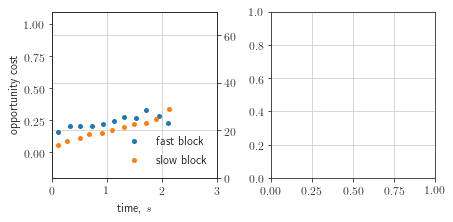

In [759]:
fig,ax=pl.subplots(1,2,figsize=(6.5,3.25))
tmax=3
max_rate=70
strvec=['fast','slow']
ax2=ax[0].twinx()
for it in range(2):
    if it==0:
        p=ax2.plot(fast_dat[:,0],fast_dat[:,1],'.',label=strvec[it]+' block')
    else:
        p=ax2.plot(slow_dat[:,0],slow_dat[:,1],'.',label=strvec[it]+' block')
ax[0].set_ylim(-0.2,1.1)
ax2.set_ylim(0,max_rate)
ax2.legend(frameon=False,prop={'size': 12},loc=4)
ax[0].set_ylabel('opportunity cost')
ax[0].yaxis.grid(False)
ax[0].xaxis.grid(True)
ax[0].set_xlim(0,tmax)
ax[0].set_xlabel(r'time, $s$')
fig.tight_layout()


In [753]:
fast_dat=np.asarray([[0.10000000000000009, 19.235021459227468],
[0.3186666666666669, 21.66266094420601],
[0.5106666666666668, 21.643090128755368],
[0.724, 22.010472103004297],
[0.9213333333333331, 22.506094420600864],
[1.124, 23.77442060085837],
[1.3159999999999998, 25.428669527897],
[1.5346666666666664, 25.04944206008584],
[1.7053333333333334, 28.376824034334767],
[1.94, 25.96377682403434],
[2.1159999999999997, 23.162575107296142]])
fast_dat_upper=np.asarray([[0.3179401993355482, 22.464436035882827],
[0.7272425249169436, 22.995365843288976],
[1.120598006644518, 25.11338803622295],
[1.5299003322259135, 27.35912588750478],
[1.9338870431893684, 28.91390672165299]])
fast_dat_lower=np.asarray([[0.3179401993355482, 20.85200459164151],
[0.7166112956810631, 20.973598061306916],
[1.120598006644518, 22.50278474554653],
[1.5299003322259135, 22.93133795331831],
[1.9338870431893684, 23.027252242676756]])
slow_dat=np.asarray([[0.10000000000000009, 13.930300429184552],
[0.27600000000000025, 15.558283261802579],
[0.5106666666666668, 16.98214592274678],
[0.6813333333333336, 18.455450643776828],
[0.9053333333333331, 19.080686695278974],
[1.092, 20.116738197424894],
[1.3053333333333335, 21.51416309012876],
[1.492, 22.781974248927042],
[1.7053333333333334, 23.0206008583691],
[1.8973333333333335, 24.67484978540773],
[2.1213333333333333, 29.085493562231765]])
slow_dat_lower=np.asarray([[0.2754152823920266, 15.170783555120956],
[0.6794019933554818, 17.928489434973002],
[1.0887043189368768, 19.45759108881425],
[1.4873754152823917, 21.882658050252964],
[1.891362126245847, 22.87436758641214]])
slow_dat_upper=np.asarray([[0.2807308970099669, 16.09208792143191],
[0.6847176079734221, 19.028952850644103],
[1.0833887043189367, 20.788571914459418],
[1.4873754152823917, 23.751030993580205],
[1.891362126245847, 26.585519323158028]])

# hand-tuned set:

In [ ]:
subject=1
model_paras_S1={'tau_context':1*average_trial_duration,  #was 20
                'tau_context_plus':30*average_trial_duration, #was 20
                'tau_long':tau_long,
                'shared_noise_variance_factor':0, #was 20
                'tau_shared_noise':tau_long*10,
                'context_noise_bias':0,#was 0.004
                'context_noise_variance_factor':0
                }
df_act=df_data[df_data.idSubject==subject].reset_index(drop=True)
df_mod_list=[]
for seed in range(10):
    df_mod_list.append(get_model_output(df_act,model_paras_S1,seed=seed))
plot_transitions({'act':df_act,'mod':df_mod_list})
# get_plots({'act':df_act,'mod':df_mod},1,1,1)

Even though looking at mean, model transition statistics have strong dependence on realization of attenational noise!

In [30]:
data_store={}
average_trial_duration=get_trial_duration(6.5,0.5)
trials_per_context=100
tau_long=10*trials_per_context*average_trial_duration

too urgent to play
too urgent to play
too urgent to play
too urgent to play
too urgent to play
too urgent to play
too urgent to play
too urgent to play
too urgent to play
too urgent to play
too urgent to play
too urgent to play
too urgent to play


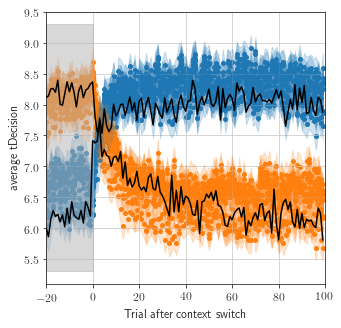

In [88]:
subject=1
model_paras_S1={'tau_context':1*average_trial_duration,  #was 20
                'tau_context_plus':30*average_trial_duration, #was 20
                'tau_long':tau_long,
                'shared_noise_variance_factor':10, #was 20
                'tau_shared_noise':tau_long*10,
                'context_noise_bias':0.004,#was 0.004
                'context_noise_variance_factor':0.2
                }
df_act=df_data[df_data.idSubject==subject].reset_index(drop=True)
df_mod_list=[]
for seed in range(10):
    df_mod_list.append(get_model_output(df_act,model_paras_S1,seed=seed))
plot_transitions({'act':df_act,'mod':df_mod_list})
# get_plots({'act':df_act,'mod':df_mod},1,1,1)

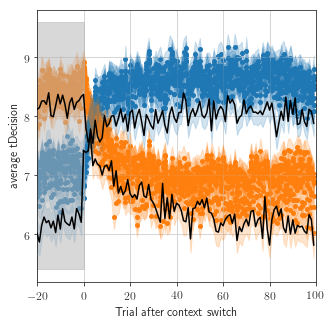

In [86]:
plot_transitions({'act':df_act,'mod':df_mod_list})

no length
no length
no length
no length
no length
no length
no length
no length
no length
no length
no length


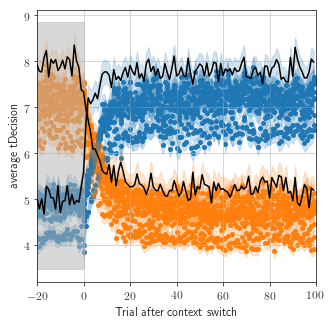

In [87]:
subject=2
model_paras_S2={'tau_context':8*average_trial_duration, #was 8
                'tau_context_plus':8*average_trial_duration, #was 40
                'tau_long':tau_long,
                'shared_noise_variance_factor':50,#was 50
                'tau_shared_noise':tau_long*30,#was 30
                'context_noise_bias':0.002,
                'context_noise_variance_factor':0.5#was 0.5
                }
df_act=df_data[df_data.idSubject==subject].reset_index(drop=True)
df_mod_list=[]
for seed in range(10):
    df_mod_list.append(get_model_output(df_act,model_paras_S2,seed=seed))
plot_transitions({'act':df_act,'mod':df_mod_list})
# df_mod=get_model_output(df_act,model_paras_S2)
# get_plots({'act':df_act,'mod':df_mod},1,1,1)

## Statistics

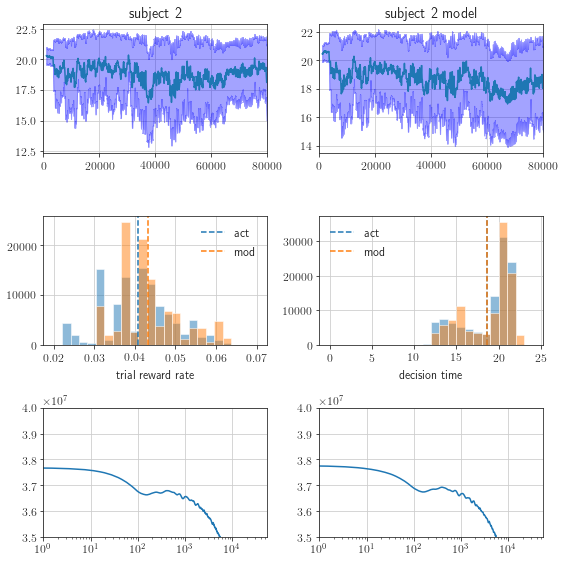

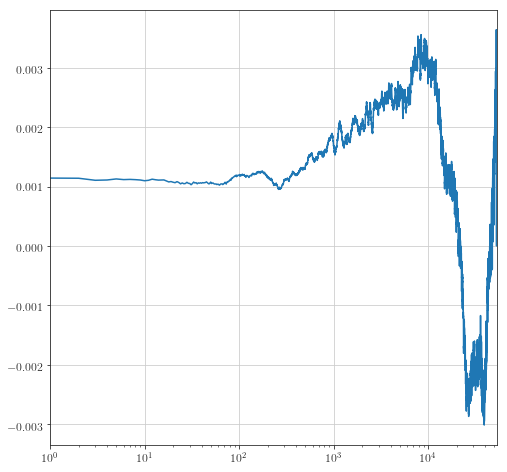

In [713]:
# for sit, subject in enumerate(range(1,3)):
#     df_act=df_data[df_data.idSubject==subject].reset_index(drop=True)
#     df_mod=get_model_output(df_act,model_paras_S1_taus)
plot_stats({'act':df_act,'mod':df_mod})

## Policy and transitions

../lib/utils/ipynb_setup.py:59: RuntimeWarning: invalid value encountered in true_divide
../lib/utils/ipynb_setup.py:92: RuntimeWarning: invalid value encountered in less


some decisions at t=0!


../lib/utils/ipynb_setup.py:59: RuntimeWarning: invalid value encountered in true_divide
../lib/utils/ipynb_setup.py:92: RuntimeWarning: invalid value encountered in less
../lib/utils/ipynb_setup.py:59: RuntimeWarning: invalid value encountered in true_divide
../lib/utils/ipynb_setup.py:92: RuntimeWarning: invalid value encountered in less
../lib/utils/ipynb_setup.py:59: RuntimeWarning: invalid value encountered in true_divide
../lib/utils/ipynb_setup.py:92: RuntimeWarning: invalid value encountered in less


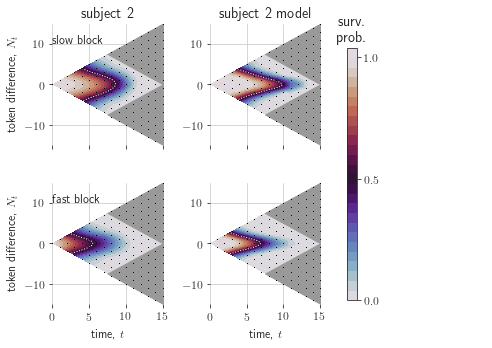

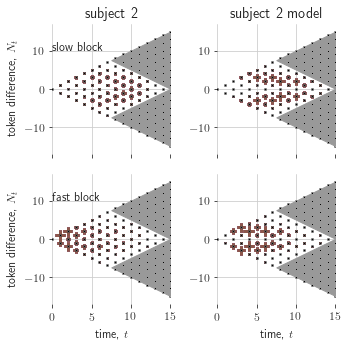

In [714]:
# for sit, subject in enumerate(range(1,3)):
plot_policies({'act':df_act,'mod':df_mod})

Switching analysis

NameError: name 'data_type' is not defined

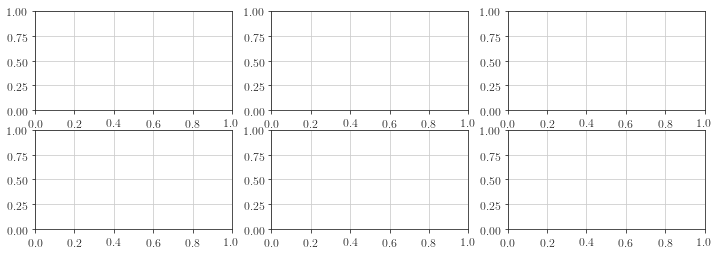

In [383]:
for sit, subject in enumerate(range(1,3)):
    fig,ax=pl.subplots(2,3,figsize=(12,4))
    for j,dtype in enumerate(data_type):
        df_tmp=data_store[subject][dtype]
        df_tmp['nPostInterval_diff']=df_tmp.nPostInterval.diff()
    
        #group transitions by fast-to-slow and slow-to-fast 
        dirstrvec=['fast to slow','slow to fast']
        for dit,interval in enumerate(block_times):
            time_depth=50
            history=20
            cond=((df_tmp.nPostInterval_diff.abs()>=time_depth) & (df_tmp.nPostInterval==interval))
            num_samples=cond.sum()
            print(num_samples)
            data_st=np.zeros((num_samples,time_depth+history))
            for it,ind in enumerate(cond[cond].index.values):
                data_st[it,:]=df_tmp.iloc[ind-history:ind+time_depth].tDecision.values
            
            binvec=np.linspace(0,14,20)
            trial_time_vec=np.arange(-history,time_depth)
            halfmaxes=np.zeros(len(trial_time_vec))
            colorsre = pl.cm.inferno_r(np.linspace(0.2, 1., len(trial_time_vec)))
            for it in range(len(trial_time_vec)):
                counts,bins=np.histogram(data_st[:,it],bins=binvec)
                cum=np.cumsum(counts)/np.sum(counts)
                ax[j,dit].plot(binvec[:-1],cum,color=colorsre[it])
                maxind=np.where(0.5<cum)[0][0]
                xmin=binvec[maxind-1]
                xmax=binvec[maxind]
                m=(cum[maxind]-cum[maxind-1])/(xmax-xmin)
                halfmaxes[it]=(0.5-cum[maxind-1])/m+xmin#np.max(counts)
                ax[j,dit].plot([halfmaxes[it]],[0.5],'o',color=colorsre[it])
            ax[j,2].plot(trial_time_vec,halfmaxes,'.-')
            ax[j,2].fill_between([-history,0],[3]*2,[9]*2,color=[0.7]*3,alpha=0.5)
            ax[j,2].set_ylim(3,9)
            ax[0,dit].set_title(dirstrvec[dit])
        ax[j,0].set_ylim(0.45,0.55)
        ax[j,1].set_ylim(0.45,0.55)
    fig.tight_layout()
#         fig.savefig('halfmax_data'+str(i)+'.pdf', transparent=True,bbox_inches="tight",dpi=300)